In [198]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize
from astropy.wcs import WCS
import os
import seaborn as sns
import pandas as pd
import pickle

# specific packages for statistics and principal component analysis
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from scipy.optimize import curve_fit

# packages for working with sparse healpix maps
import healsparse as hsp
import skyproj

#packages for working with healpy healpix maps
import healpy as hp

# LSST packages
from lsst.daf.butler import Butler
import lsst.geom as geom

# allow interactive plots
%matplotlib widget

# default plot style is accessible
plt.style.use('tableau-colorblind10')

In [2]:
config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collections)

In [3]:
hspmap = butler.get('deepCoadd_psf_maglim_consolidated_map_weighted_mean', band='i')

In [137]:
nside_coverage = hspmap.nside_coverage
nside_sparse = hspmap.nside_sparse
print('nside_coverage = ', hspmap.nside_coverage)
print('nside_sparse = ', hspmap.nside_sparse)

nside_coverage =  32
nside_sparse =  512


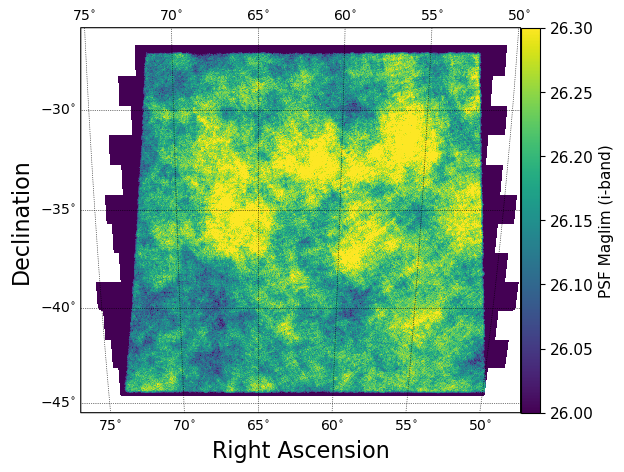

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax, lon_0=65.0)
sp.draw_hspmap(hspmap, vmin=26.0, vmax=26.3)
sp.draw_colorbar(label='PSF Maglim (i-band)')
plt.show()

del fig, ax, sp

# Degrade the SP map to lower nside resolution 

In [102]:
deg_nside = 512

In [7]:
hspmap = hspmap.degrade(deg_nside)

In [9]:
print('nside_coverage = ', hspmap.nside_coverage)
print('nside_sparse = ', hspmap.nside_sparse)

nside_coverage =  32
nside_sparse =  512


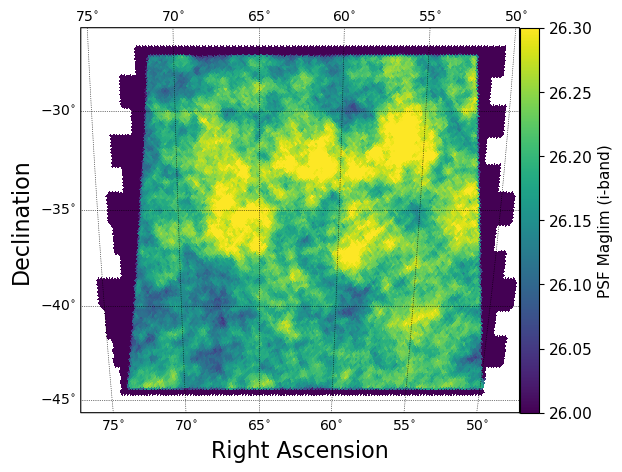

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax, lon_0=65.0)
sp.draw_hspmap(hspmap, vmin=26.0, vmax=26.3)
sp.draw_colorbar(label='PSF Maglim (i-band)')
plt.show()

del fig, ax, sp

# Binning the SP maps on sky 

In [6]:
def equal_area_bin_edges(map_data,nbins):
        data_min = map_data.min()
        data_max = map_data.max()
        pix_per_bin = int(len(map_data)/nbins)

        data_sort = np.sort(map_data)
        if nbins*pix_per_bin==len(map_data):
                data_sort = np.append(data_sort,data_max)
        binedges = [data_sort[i*pix_per_bin] for i in range(nbins+1)]
        binedges[-1] = data_max

        if len(np.unique(binedges)) != len(binedges):
                raise RuntimeError('Your bin edges are not unique please set them manually')

        return binedges

In [11]:
valid_pix = hspmap.valid_pixels

In [12]:
sp_ra, sp_dec = hspmap.valid_pixels_pos(lonlat=True)

In [13]:
vals = hspmap.get_values_pix(valid_pix, nest=True)

In [14]:
print(len(valid_pix),len(vals),len(sp_ra))

26724 26724 26724


In [25]:
binedges1d = equal_area_bin_edges(vals,nbins=4)

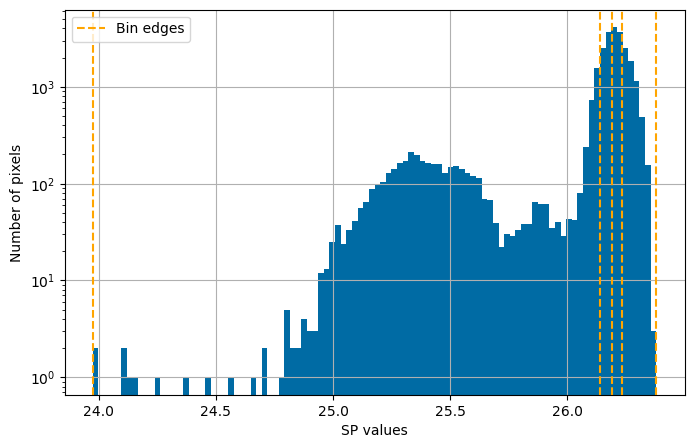

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
_ = plt.hist(vals,bins=100)
for spbin in binedges1d:
    plt.axvline(x=spbin,ls='--',color='orange')
plt.plot([],[],ls='--',color='orange',label='Bin edges')
plt.grid()
plt.yscale("log")
plt.xlabel('SP values')
plt.ylabel('Number of pixels')
plt.legend(loc="upper left")
plt.show()

del fig, ax

In [22]:
sky_bins = np.ones(len(valid_pix))
for ibin in range(len(binedges1d)-1):
    ibin_mask = (vals>binedges1d[ibin])*(vals<binedges1d[ibin+1])
    sky_bins[ibin_mask] = ibin+1

In [106]:
hsp_bins = hsp.HealSparseMap.make_empty(hspmap.nside_coverage, hspmap.nside_sparse, dtype=np.float64)
hsp_bins.update_values_pix(valid_pix, sky_bins,operation='replace')

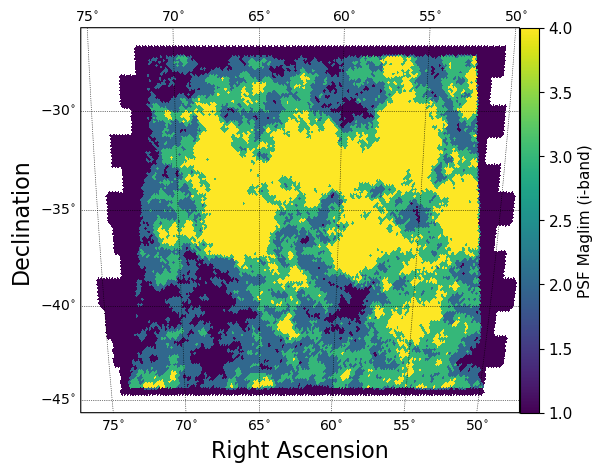

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax, lon_0=65.0)
sp.draw_hspmap(hsp_bins)
sp.draw_colorbar(label='PSF Maglim (i-band)')
plt.show()

del fig, ax, sp

Let's load additional SP maps at nside = 512 

In [59]:
sp_names = []
for dtype in sorted(butler.registry.queryDatasetTypes(expression="*consolidated_map*")):
    print(dtype.name)
    sp_names.append(dtype.name)

deepCoadd_dcr_ddec_consolidated_map_weighted_mean
deepCoadd_dcr_dra_consolidated_map_weighted_mean
deepCoadd_dcr_e1_consolidated_map_weighted_mean
deepCoadd_dcr_e2_consolidated_map_weighted_mean
deepCoadd_exposure_time_consolidated_map_sum
deepCoadd_psf_e1_consolidated_map_weighted_mean
deepCoadd_psf_e2_consolidated_map_weighted_mean
deepCoadd_psf_maglim_consolidated_map_weighted_mean
deepCoadd_psf_size_consolidated_map_weighted_mean
deepCoadd_sky_background_consolidated_map_weighted_mean
deepCoadd_sky_noise_consolidated_map_weighted_mean


In [60]:
sp_names = ['deepCoadd_exposure_time_consolidated_map_sum',
            'deepCoadd_psf_maglim_consolidated_map_weighted_mean',
            'deepCoadd_psf_size_consolidated_map_weighted_mean',
            'deepCoadd_sky_background_consolidated_map_weighted_mean']

In [29]:
band = 'i'

In [46]:
map_dict = {}
for name in sp_names:
    hspmap_ = butler.get(name, band='i')
    hspmap_ = hspmap_.degrade(512)
    dict_ = {}
    dict_['nside_coverage'] = hspmap_.nside_coverage
    dict_['nside_sparse'] = hspmap_.nside_sparse
    valid_pixels_ = hspmap_.valid_pixels
    dict_['valid_pixels'] = valid_pixels_
    dict_['map_values'] = np.array(hspmap_.get_values_pix(valid_pixels_, nest=True))
    
    map_dict[name] = dict_
    del hspmap_
    

In [105]:
#val_pix_ref = map_dict[sp_names[0]]['valid_pixels']
for sp in sp_names:
    print((map_dict[sp]['valid_pixels']==valid_pix).all())

True
True
True
True


In [51]:
map_dict[sp_names[0]]

{'nside_coverage': 32,
 'nside_sparse': 512,
 'valid_pixels': array([2178399, 2178415, 2178419, ..., 2312224, 2312225, 2312226]),
 'map_values': array([992.68421053, 900.        , 884.52631579, ..., 889.5703125 ,
        856.13942308, 834.67788462])}

In [80]:
corr_matrix_p = np.zeros((len(sp_names),len(sp_names)))
for i,map_i in enumerate(sp_names):
    vals_i = np.array(map_dict[map_i]['map_values'])
    for j,map_j in enumerate(sp_names):
        vals_j = map_dict[map_j]['map_values']
        corr_matrix_p[i,j] = stats.pearsonr(vals_i,vals_j)[0]
print(corr_matrix_p)

[[ 1.          0.97033661 -0.39521065 -0.14972244]
 [ 0.97033661  1.         -0.52339769 -0.29192293]
 [-0.39521065 -0.52339769  1.          0.31071979]
 [-0.14972244 -0.29192293  0.31071979  1.        ]]


In [81]:
corr_matrix_s = np.zeros((len(sp_names),len(sp_names)))
for i,map_i in enumerate(sp_names):
    vals_i = np.array(map_dict[map_i]['map_values'])
    for j,map_j in enumerate(sp_names):
        vals_j = map_dict[map_j]['map_values']
        corr_matrix_s[i,j] = stats.spearmanr(vals_i,vals_j)[0]
print(corr_matrix_s)

[[ 1.          0.80449459 -0.23458658 -0.04936673]
 [ 0.80449459  1.         -0.59449993 -0.41152335]
 [-0.23458658 -0.59449993  1.          0.3044255 ]
 [-0.04936673 -0.41152335  0.3044255   1.        ]]


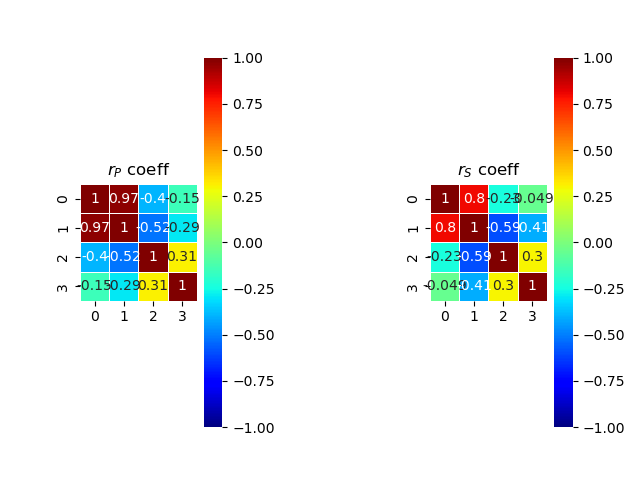

In [82]:
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
sns.heatmap(corr_matrix_p,vmin=-1.0,vmax=1.0,annot=True,cmap='jet',linewidth=0.5,square=True,cbar=True)
plt.title(r'$r_P$ coeff')
ax2 = fig.add_subplot(1,3,3)
plt.title(r'$r_S$ coeff')
sns.heatmap(corr_matrix_s,vmin=-1.0,vmax=1.0,annot=True,cmap='jet',linewidth=0.5,square=True,cbar=True)

del fig, ax1, ax2

# Do principal component analysis (PCA) of the SP maps 

In [88]:
def pca_summary(pca, standardised_data, out=True):
        names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
        a = list(np.std(pca.transform(standardised_data), axis=0))
        b = list(pca.explained_variance_ratio_)
        c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1,len(pca.explained_variance_ratio_)+1)]
        columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
        summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
        if out:
                print("Importance of components:")
                display(summary)
        return summary

In [124]:
def screeplot(pca, standardised_values, figsize):
        y = np.std(pca.transform(standardised_values), axis=0)**2
        x = np.arange(len(y)) + 1
        fig = plt.figure(figsize=figsize)
        fig.set_tight_layout(True)
        plt.plot(x, y, "o-")
        plt.xticks(x, ["Comp."+str(i) for i in x], ha='right', rotation=50, fontsize=12)
        plt.ylabel("Variance")
        plt.grid()
        plt.show()
        #plt.close()

In [83]:
data_dict = {}
for key in map_dict:
    data_dict[key] = map_dict[key]['map_values']

In [85]:
dataframe = pd.DataFrame(data_dict)

In [86]:
standard = scale(dataframe)
standard_df = pd.DataFrame(standard,columns=dataframe.columns)
pca = PCA().fit(standard_df)

In [90]:
summary = pca_summary(pca, standard_df)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,1.556330,0.605540,0.605540
PC2,0.977318,0.238788,0.844328
PC3,0.781187,0.152563,0.996892
PC4,0.111508,0.003108,1.000000


In [91]:
summary.to_csv('data_frame.csv',header=True)

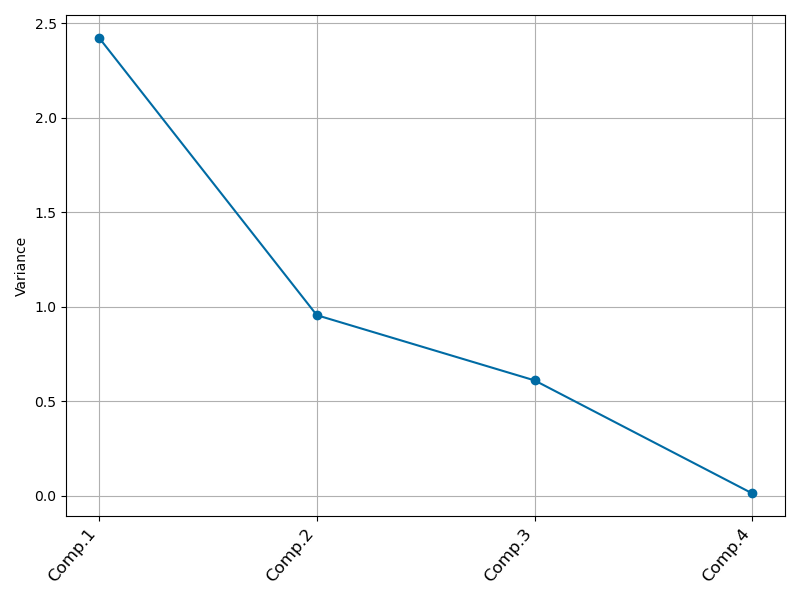

In [98]:
screeplot(pca, standard_df, figsize=(8,6))

In [100]:
print(pca.components_)

[[-0.57711345 -0.61824892  0.45041253  0.28607149]
 [ 0.39548071  0.22673626  0.28172055  0.84428622]
 [-0.25057785 -0.17365151 -0.84204807  0.44498421]
 [ 0.66913812 -0.73225958 -0.09336563 -0.08563257]]


In [101]:
print(pca.components_[0])

[-0.57711345 -0.61824892  0.45041253  0.28607149]


PC 1


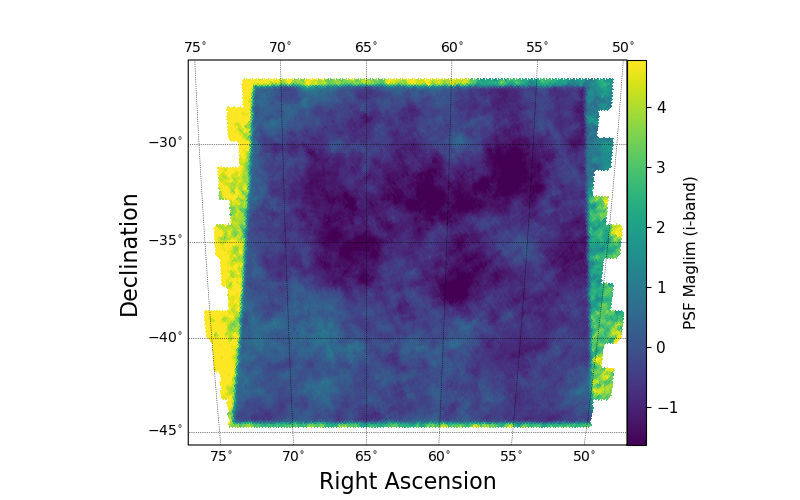

PC 2


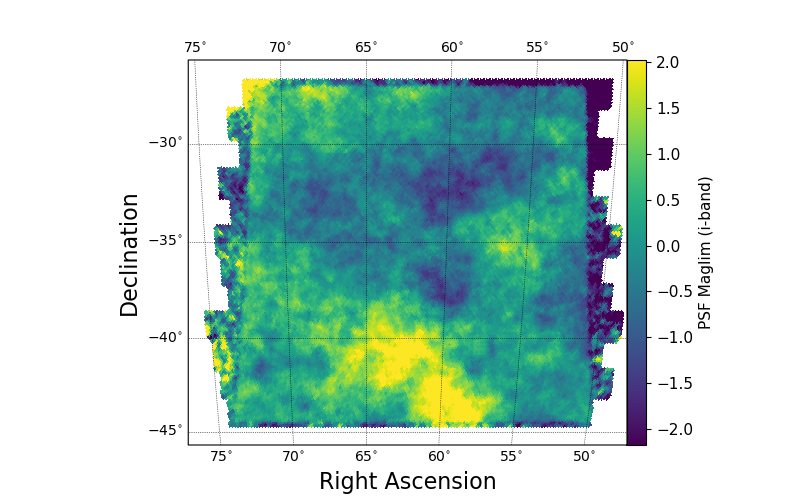

PC 3


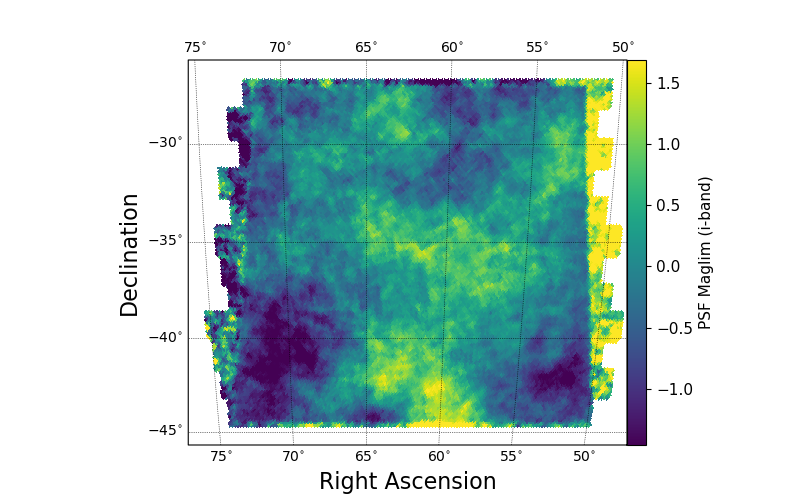

PC 4


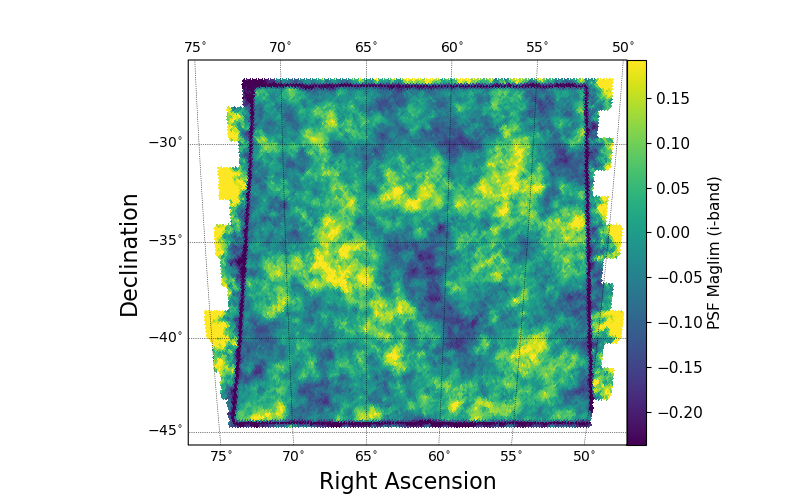

In [114]:
for i in range(len(sp_names)):
        print('PC {0}'.format(i+1))
        pcavalues = pca.transform(standard_df)[:,i]
        
        hsp_pca_ = hsp.HealSparseMap.make_empty(hspmap.nside_coverage, deg_nside, dtype=np.float64)
        hsp_pca_.update_values_pix(valid_pix, pcavalues,operation='replace')
        
        assert (hsp_pca_.valid_pixels==valid_pix).all()
        
        fig, ax = plt.subplots(figsize=(8, 5))
        sp = skyproj.McBrydeSkyproj(ax=ax, lon_0=65.0)
        sp.draw_hspmap(hsp_pca_)
        sp.draw_colorbar(label='PSF Maglim (i-band)')
        plt.show()

        del fig, ax, sp

# Load galaxies from dp02_dc2_catalogs.Object and create number galaxy map 
We previously saved the colums that we are interested in from dp02_dc2_catalogs.Object in a pickle file


In [142]:
def cat2map(ra,dec,nside,weight=None):
        theta = np.radians(90.-dec)
        phi = np.radians(ra)
        
        map1 = np.zeros(hp.nside2npix(nside))
        p = hp.ang2pix(nside,theta,phi,nest=True)
        #print(p)
        mask = np.zeros(hp.nside2npix(nside)).astype('bool')
        mask[p] = True
        if weight is None:
                for i in p:
                        map1[i] += 1
        else:
                for index,i in enumerate(p):
                        map1[i] += weight[index]
        map1[~mask] = hp.UNSEEN
        pix_ra, pix_dec = hp.pix2ang(nside,np.unique(p),nest=True,lonlat=True)
        
        return map1, mask, np.unique(p), pix_ra, pix_dec

In [117]:
with open('/scratch/mrmonroy/survpropmap/sources_result.pkl','rb') as f:
    cat_table = pickle.load(f)

In [118]:
cat_table

,coord_ra,coord_dec,detect_isPrimary,r_calibFlux,r_cModelFlux,refExtendedness
0,62.220625,-44.629998,False,173.178582,132.491280,1.0
1,62.241656,-44.629985,False,230.778401,176.026717,1.0
2,62.114578,-44.629982,False,894.250837,877.876788,1.0
3,61.979583,-44.629978,False,484.342187,374.583470,0.0
4,61.979582,-44.629977,False,459.123912,375.357147,0.0
...,...,...,...,...,...,...
4999995,67.586886,-44.178135,False,7.772191,105.023195,1.0
4999996,67.586888,-44.178131,True,47.948343,108.022556,1.0
4999997,68.250533,-44.178129,True,467.170295,488.515855,1.0
4999998,67.552159,-44.178124,False,490.601763,301.776619,1.0


In [119]:
ra = cat_table['coord_ra']
dec = cat_table['coord_dec']
refext = cat_table['refExtendedness']

In [120]:
sel_mask = (refext==1.0)

In [121]:
sel_ra = np.array(ra[sel_mask])
sel_dec = np.array(dec[sel_mask])

In [122]:
print(len(sel_ra))
print(sel_ra.min(),sel_ra.max())
print(sel_dec.min(),sel_dec.max())

4790606
49.1566418 74.6545933
-44.6299997 -38.870624


In [143]:
ngal_vals, mask, gal_pixels, pix_ra, pix_dec = cat2map(sel_ra,sel_dec,deg_nside)

In [144]:
assert (np.sum(ngal_vals[mask])==len(sel_ra))

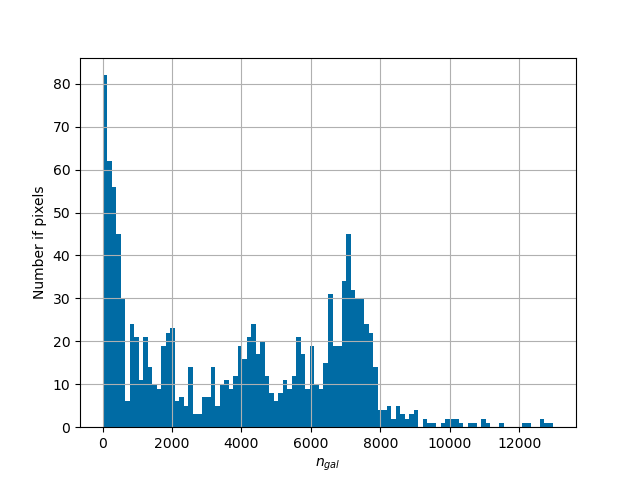

In [131]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
n,bins,_ = ax.hist(ngal_vals[mask],bins=100)
ax.grid()
ax.set_xlabel(r'$n_{gal}$')
ax.set_ylabel('Number if pixels')

del fig, ax

In [147]:
hsp_map_ngal = hsp.HealSparseMap.make_empty(nside_coverage, deg_nside, dtype=np.float64)
pixels_ngal = hp.ang2pix(deg_nside, np.radians(90. - pix_dec), np.radians(pix_ra), nest=True)
assert (len(np.unique(pixels_ngal))==len(pixels_ngal))
hsp_map_ngal.update_values_pix(pixels_ngal, ngal_vals[mask],operation='replace')

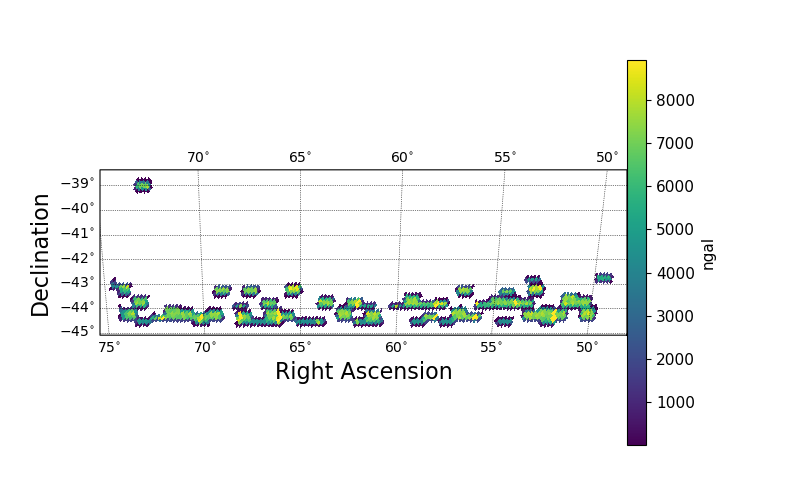

In [148]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax, lon_0=65.0)
sp.draw_hspmap(hsp_map_ngal)
sp.draw_colorbar(label='ngal')
plt.show()

del fig, ax, sp

In [155]:
(hsp_map_ngal.get_values_pix(gal_pixels)==ngal_vals[mask]).all()

True

Now we evaluate the SP maps in the same regions where the $n_{gal}$ map is defined 

In [149]:
hspmap_masked = hsp.HealSparseMap.make_empty(nside_coverage, deg_nside, dtype=np.float64)
hspmap_masked.update_values_pix(gal_pixels, hspmap.get_values_pix(gal_pixels, nest=True),operation='replace')

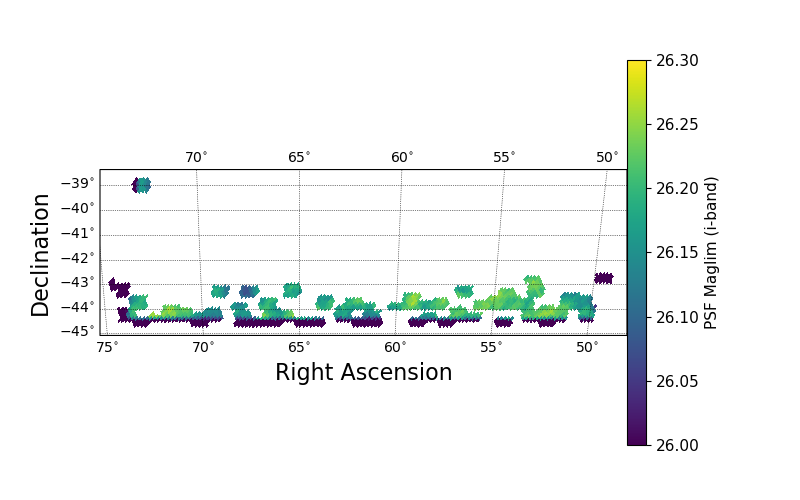

In [151]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax, lon_0=65.0)
sp.draw_hspmap(hspmap_masked, vmin=26.0, vmax=26.3)
sp.draw_colorbar(label='PSF Maglim (i-band)')
plt.show()

del fig, ax, sp

Let's mask all the SP maps 

In [145]:
masked_map_dict = {}
for name in sp_names:
    hspmap_ = butler.get(name, band='i')
    hspmap_ = hspmap_.degrade(deg_nside)
    assert (hspmap_.nside_sparse==hsp_map_ngal.nside_sparse)
    
    dict_ = {}
    dict_['nside_coverage'] = hspmap_.nside_coverage
    dict_['nside_sparse'] = hspmap_.nside_sparse
    dict_['map_values'] = np.array(hspmap_.get_values_pix(gal_pixels, nest=True))
    
    masked_map_dict[name] = dict_
    del hspmap_
    

# Compute 1D relations 
We define the function to compute them 

In [176]:
def bin1d_coords(ngal_map,mask,sp_map_vals,nbins1d):
    ngal_vals = ngal_map[mask]
    ngal_footprint = np.average(ngal_vals)
    
    binedges1d = equal_area_bin_edges(sp_map_vals,nbins=nbins1d)
    
    sp_in_bin1d = []
    ngal_in_bin1d = []
    err_in_bin1d = []
    for ibin in range(len(binedges1d)-1):
        ibin_mask = (sp_map_vals>binedges1d[ibin])*(sp_map_vals<binedges1d[ibin+1])
        
        sp_in_bin1d_ = np.average(sp_map_vals[ibin_mask])
        ngal_in_bin1d_ = np.average(ngal_vals[ibin_mask])
        err_in_bin1d_ = np.std(ngal_vals[ibin_mask])/np.sqrt(len(ngal_vals[ibin_mask]))
        
        sp_in_bin1d.append(sp_in_bin1d_)
        ngal_in_bin1d.append(ngal_in_bin1d_)
        err_in_bin1d.append(err_in_bin1d_)
    
    sp_in_bin1d = np.array(sp_in_bin1d)
    ngal_in_bin1d = np.array(ngal_in_bin1d)
    err_in_bin1d = np.array(err_in_bin1d)
    
    return sp_in_bin1d, ngal_in_bin1d, err_in_bin1d, ngal_footprint
    

In [191]:
def fun_fit(x,a,b,c):
    return a*x**2.+b*x+c

Let's plot an example 

In [194]:
nbins1d = 10

In [192]:
sp_x,ngal_y,ngal_err,ngal_mean = bin1d_coords(ngal_vals,mask,masked_map_dict[sp_names[0]]['map_values'],nbins1d=nbins1d)

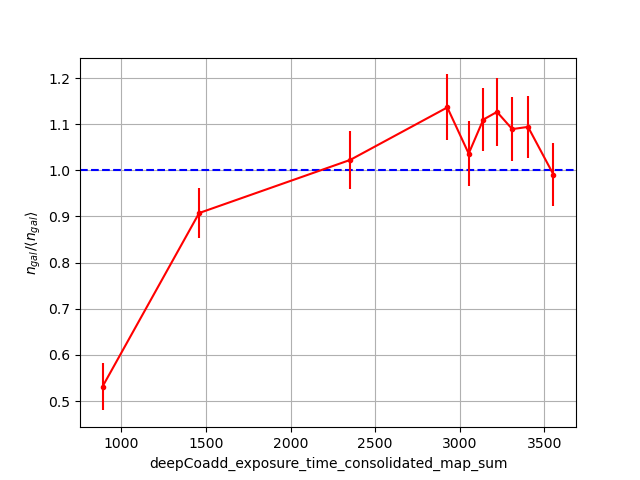

In [205]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.axhline(y=1.0,ls='--',color='b')
ax.plot(sp_x,ngal_y/ngal_mean,color='r')
plt.errorbar(sp_x,ngal_y/ngal_mean,yerr=ngal_err/ngal_mean,fmt='.',color='r')
ax.grid()
ax.set_xlabel(sp_names[0])
plt.ylabel(r'$n_{gal}/\langle n_{gal} \rangle$')
plt.show()

Now let's do this for all SP maps and fit each 1D relation with a quadratic function 

In [199]:
dict_1d = {}
for name in sp_names:
    dict_1d_ = {}
    
    sp_x_,ngal_y_,ngal_err_,ngal_mean_ = bin1d_coords(ngal_vals,mask,masked_map_dict[name]['map_values'],nbins1d=nbins1d)
    
    p0,cov0 = curve_fit(fun_fit,sp_x_,ngal_y_/ngal_mean_,sigma=ngal_err_/ngal_mean_)
    ngal_fit_ = fun_fit(sp_x_,p0[0],p0[1],p0[2])
    
    dict_1d_['x'] = sp_x_
    dict_1d_['y'] = ngal_y_
    dict_1d_['err'] = ngal_err_
    dict_1d_['ngal_mean'] = ngal_mean_
    dict_1d_['yfit'] = ngal_fit_
    
    dict_1d[name] = dict_1d_

In [214]:
dict_1d.keys()

dict_keys(['deepCoadd_exposure_time_consolidated_map_sum', 'deepCoadd_psf_maglim_consolidated_map_weighted_mean', 'deepCoadd_psf_size_consolidated_map_weighted_mean', 'deepCoadd_sky_background_consolidated_map_weighted_mean'])

In [212]:
sp_names

['deepCoadd_exposure_time_consolidated_map_sum',
 'deepCoadd_psf_maglim_consolidated_map_weighted_mean',
 'deepCoadd_psf_size_consolidated_map_weighted_mean',
 'deepCoadd_sky_background_consolidated_map_weighted_mean']

IndexError: list index out of range

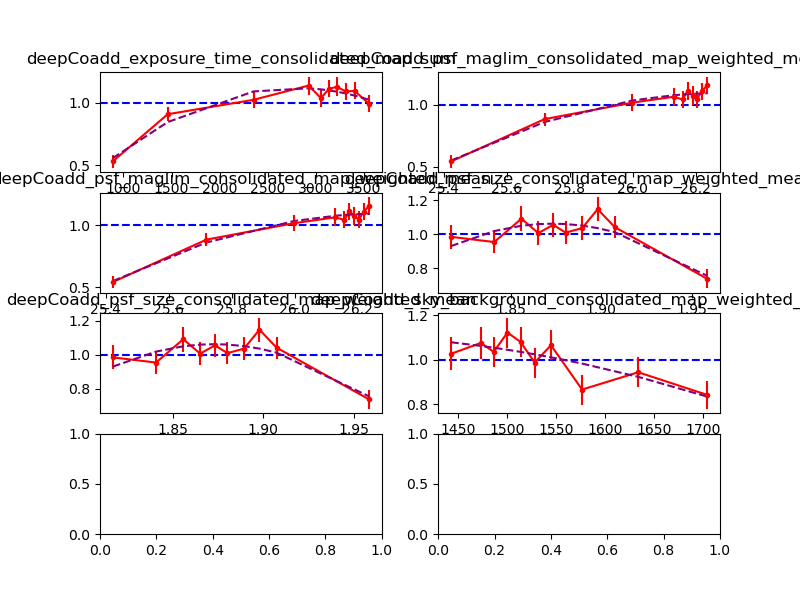

In [215]:
num_columns = 2
num_rows = len(sp_names)+len(sp_names)%2
fig, axs = plt.subplots(num_rows, num_columns, figsize=(8,6))

index_list = []
for row in range(num_rows):
    for col in range(num_columns):
        if name not in index_list:
            sp_name = sp_names[row+col]
        else:
            sp_name = sp_names[row+col+1]
            
        index_list.append(sp_name)
            
        ngal_mean_ = dict_1d[sp_name]['ngal_mean']
        x_ = dict_1d[sp_name]['x']
        y_ = dict_1d[sp_name]['y']/ngal_mean_
        err_ = dict_1d[sp_name]['err']/ngal_mean_
        yfit_ = dict_1d[sp_name]['yfit']
            
        axs[row,col].axhline(y=1.0,ls='--',color='b')
        axs[row,col].plot(x_,y_,color='r')
        axs[row,col].errorbar(x_,y_,yerr=err_,fmt='.',color='r')
        axs[row,col].plot(x_,yfit_,ls='--',color='purple')
        axs[row,col].set_title(sp_name)
        
plt.tight_layout()
plt.show()
del fig, axs
print(index_list)